In [1]:
import psycopg2
from config import local_host, local_name, local_port, local_user
from creds import local_db_password
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
conn = psycopg2.connect(dbname=local_name, user =local_user, host=local_host, password=local_db_password, port =local_port)
cur = conn.cursor()

In [2]:
player_selection = """
select 
    player_id
from ffl.fixtures_tactics
where position = 'F'
group by 1
"""

In [3]:
def fetch_player_data(input_id=None):
	player_model_fetch = f"""
	select
		fixture_id,
		{input_id} as player_id,
		avg(player_performance_mod) filter (where team_position = 'G' and team_side = 'opponent' and fixture_id = fixture_id) as goal_o,
		avg(player_performance_mod) filter (where team_position = 'D' and team_side = 'opponent') as def_o,
		avg(player_performance_mod) filter (where team_position = 'M' and team_side = 'opponent') as mid_o,
		avg(player_performance_mod) filter (where team_position = 'F' and team_side = 'team') as fwd_t,
		avg(player_performance_mod) filter (where team_position = 'M' and team_side = 'team') as mid_t,
		avg(player_performance_mod) filter (where player_id = {input_id}) as player_benchmark,
		coalesce(max(points_per_min) filter (where fixture_id = fixture_id and player_id = {input_id}), 0) as outcome_val
	from (
		select 
		fix.fixture_id as fixture_id,
		fix.team_id as team_id,
		fix.player_id as player_id,
		fix.position as team_position,
		stats.player_performance_mod,
		outcome.points_per_min as points_per_min,
		case 
			when fix.team_id in (select current_team_id from ffl.players where id = {input_id}) then 'team'
		else 'opponent' end as team_side
	from ffl.fixtures_tactics as fix
	left join 
		(select 
			player_id, 
			avg(coalesce(rating::double precision, 0)) as player_performance_mod
		from ffl.fixture_player_performance
		where fixture_id in (select fixture_id from ffl.fixtures_tactics)
		group by player_id) as stats on stats.player_id = fix.player_id
	left join
		(select
		fixture_id,
		player_id,
		coalesce(cast((goals_total::double precision + assists::double precision) / minutes::double precision as double precision), 0.00) as points_per_min
		from ffl.fixture_player_performance 
		where 
		player_id = {input_id} and minutes::int > 0) as outcome on outcome.fixture_id = fix.fixture_id and outcome.player_id = fix.player_id
	) a
	group by 1
	having fixture_id in (select fixture_id from ffl.fixtures_tactics where player_id = {input_id} group by 1)

	"""

	return player_model_fetch

In [4]:
fwd_list = []
cur.execute(player_selection)
for player in cur.fetchall():
    fwd_list.append(player[0])

In [5]:
player_df = pd.DataFrame(columns=['fixture_id', 'player_id', 'goal_o', 'def_o', 'mid_o', 'fwd_t', 'mid_t', 'player_bench', 'outcome_val'])

In [6]:
for player in fwd_list:
    cur.execute(fetch_player_data(player))
    for i in cur.fetchall():
        player_df.loc[len(player_df)] = i

In [7]:
player_df.head()

,fixture_id,player_id,goal_o,def_o,mid_o,fwd_t,mid_t,player_bench,outcome_val
0,1035063.0,83.0,7.366667,6.878819,7.039236,5.200000,6.007222,5.2,0.000000
1,1035076.0,83.0,6.911111,6.505556,6.060556,6.469444,6.375347,5.2,0.011111
2,1035079.0,83.0,5.350000,6.707986,6.141667,5.716667,6.536944,5.2,0.000000
3,1035112.0,104.0,6.911111,5.414815,6.358413,5.760909,7.030976,4.1,0.000000
4,1035126.0,104.0,7.277778,7.081597,6.995556,4.100000,6.626520,4.1,0.000000


In [8]:
player_df.describe()
def df_clean(dataframe=None, activate_or_not=False):
    if activate_or_not == False:
        pass
    elif activate_or_not == True:
        dataframe = dataframe.dropna(axis=0, how='any')
        return dataframe

player_df = df_clean(player_df, True)

In [9]:
from sklearn.preprocessing import StandardScaler
standard_df = player_df.copy()
for col in standard_df.describe().columns[2:8]:
    scaler = StandardScaler()
    standard_df[col] = scaler.fit_transform(standard_df[col].values.reshape(-1, 1))

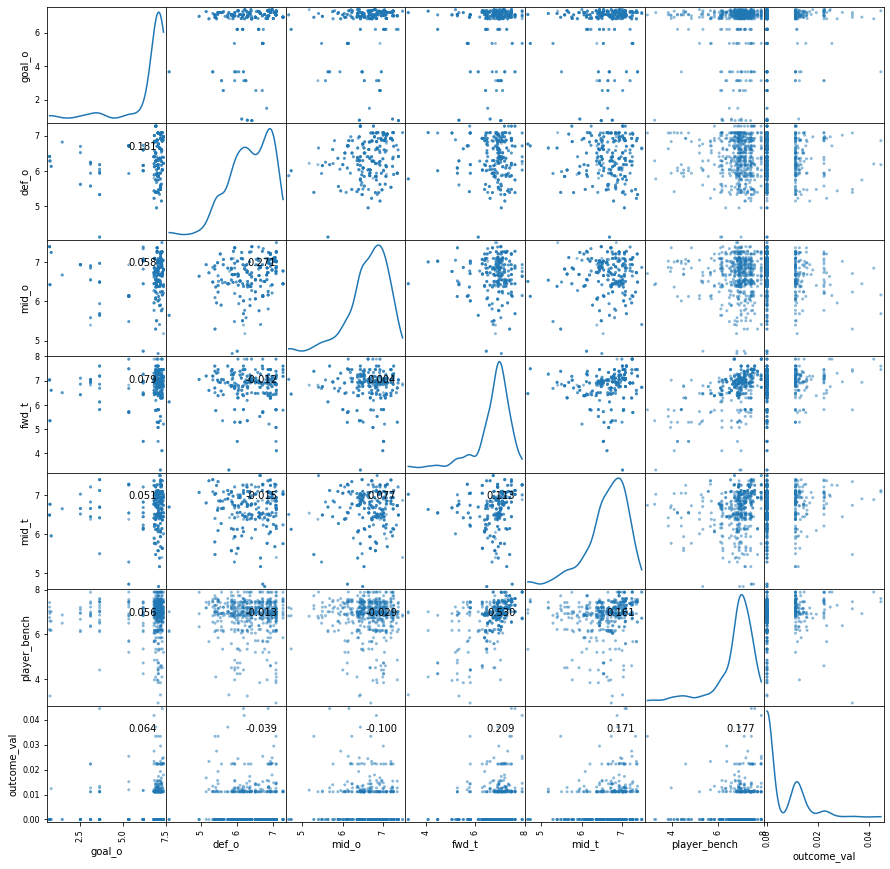

In [10]:
qual_cols = ['fixture_id', 'player_id']
axes = pd.plotting.scatter_matrix(player_df.drop(qual_cols, axis=1), figsize=(15,15), diagonal='kde', alpha=0.5)
corr = player_df.drop(qual_cols, axis=1).corr().to_numpy()
for i, j in zip(*plt.np.tril_indices_from(axes, k=-1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

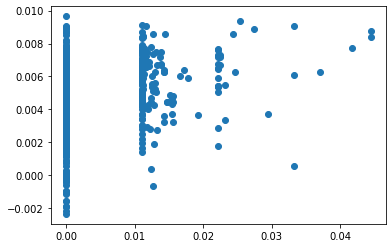

0.08371279646487384
goal_o ---- 0.00027896437744352954
def_o ---- -0.00019510374238892255
mid_o ---- -0.001782852262902858
fwd_t ---- 0.0017681400547264958
mid_t ---- 0.00230845787983322
player_bench ---- 0.000661783095826289
intercept-----0.015786439127265833


In [11]:
from sklearn.linear_model import LinearRegression
model_df = player_df

X = model_df.drop(['fixture_id', 'player_id', 'outcome_val'], axis=1)
y = model_df['outcome_val']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.scatter(y, y_pred)
plt.show()
print(model.score(X, y))

for col in range(len(X.columns)):
    print(f'{X.columns[col]} ---- {model.coef_[col]}')
print(f'intercept----{model.intercept_}')


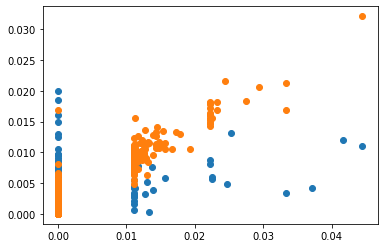

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

reg = RandomForestRegressor()
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, reg.predict(X_train))
plt.show()